# Predicting Continuous Target Variable with Regression Analysis
__Reference:__ Python Machine Learning 3rd Edition by Sebatian Raschka & Vahid Mirkalili

This is a technical research for Regression Analysis using sample housing dataset. This file includes explanation of Simple Linear Regression down to the details and example codes that can be implemented in other datasets for predictive maintenance. I am using the sample housing dataset from https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch10/housing.data.txt.

## Simple Linear Regression

The __Goal__ of the simple linear regression is to model the relationship between a single feature (explanatory variable, x) and a continuous-valued target (response variable, y).

In [1]:
import pandas as pd

df= pd.read_csv("../Data/housing_dataset.txt", header=None, sep="\s+")
df.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
# Drop the last row which is showing null value. Or else there will be error in heatmap.
df= df.drop(df.index[[506]])
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


The dataset is summarized as follows:

- CRIM: Per capita crime rate by town
- ZN: Proportion of residential and zoned for lots over 25,000 sq.ft.
- INDUS: Proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (=1 if tract bounds river and 0 otherwise)
- NOX: Nitirc oxide concentration (parts per 10 million)
- RM: Average number of rooms per dwelling
- AGE: Proportion of owner-occupied units built prior to 1940
- DIS: Weighted distances to five Boston employment centers
- RAD: Index of accessability to radial highways
- TAX: Full-value property tax rate per USD 10,000
- RTRATIO: Pupil-teacher ratio by town
- B: 1000(Bk-0.63)^2, where Bk is the proportion of [people of African American descent] by town
- LSTAT: Percentage of lower status of the population
- MEDV: Median value of owner-occupied homes in USD 1,000s.

For this research, MEDV is the target varable - the variable that we want to predict using one or more of the 13 explanatory variable. 

## Exploring the Housing dataset 

### Visualizing the important characteristics of a dataset

__Explanatory Data Analysis (EDA)__ is an important and recommended first step prior to the training of a machine learning model. Graphical EDA is preferred. The purpose is to detect the presence of outliers, the distribution of the data, and the relationship between features. First, scatterplot matrix will allow us to visualize the pair-wise correlations between the different dataset in one place.

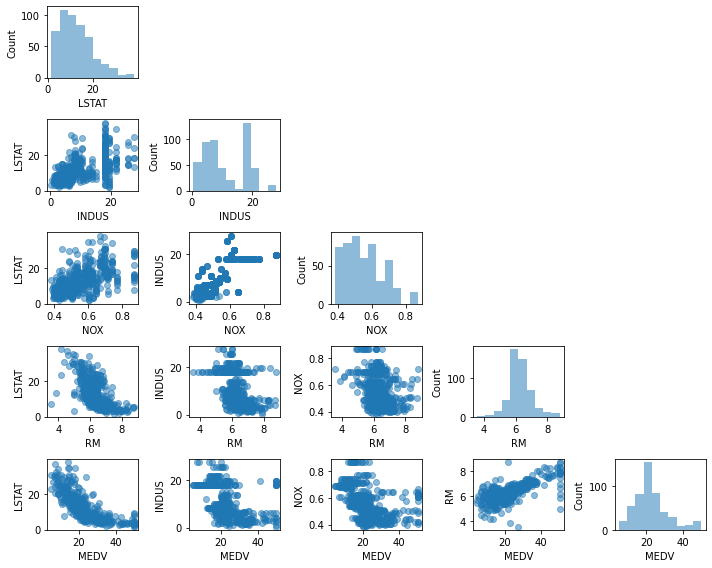

In [2]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

import warnings
warnings.filterwarnings('ignore')

# You can try all the columns for scatterplot but we will not for spacial and presentation reasons.
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10,8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

Using the scatterplot, we can quickly identify the outliers and relationships. In this case, there is a linear relationship between Average number of rooms per dwelling (RM) and house prices (MEDV). Furthermore, we can see that the MEDV variable is normally distributed with a few outliers in the bottom right corner.

__Note__: Training a linear regression model does not require that the explanatory or target variables are normally distributed. Normality assumption is only a requirement for certain statistics and hypothesis tests.

### Looking at relationships using a correlation matrix

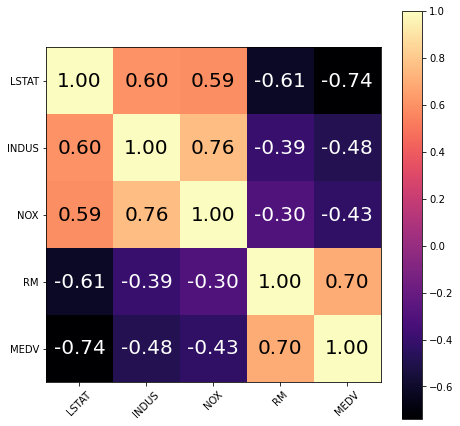

In [3]:
from mlxtend.plotting import heatmap
import numpy as np

cm = np.corrcoef(df[cols].values.T)
heatmap(cm, 
        column_names=cols, 
        row_names=cols,
        cmap = 'magma',
        figsize =(7.5, 7.5),
        cell_font_size = 20)
plt.show()

To fit a linear regression model, we are interested in those features that have a high correlation with the target variable, MEDV. The Heatmap correlation matrix shows the largest correlation between MEDV and LSTAT variable (-0.74); however, scatterplot matrix shows a clear non-linear relationship between LSTAT and MEDV. On the otherhand, the correlation between RM and MEDV is also relatively high (0.70). Given the linear relationship between these two variables that we observed in the scatterplot, RM seems to be a good choice for an exploratory variable to introduce the concepts of a simple linear regression model in the following section.

<img src="../Images/linearity.png"/>

## Implementing an ordinary least squares linear regression model

In the following subsections, we will use __ordinary least squares (OLS)__ method (sometimes also called __linear least squares__) to estimate the parameters of the linear regression line that minimizes the sum of the squared vertical distances (residuals or errors) to the training examples.

### Solving regression for regression parameters with gradient descent

OLS regression can be understood as Adaptive Linear Neurons (ADALINE) without the unit step function so that we can obtain continuous target values instead of the class labels -1 and 1. ADALINE is used for classification, but we want linearity/continuity. Hence, from my understanding, we are removing the unit step function that helps ADALINE classify into -1 and 1.

__PS__: Codes for ADALINE is added for viewing.

#### Code Example for ADALINE Implemetation with Unit Step Function

```python
class AdalineGD(object):
    """ADAaptive LInear NEuron classifier.
    
    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight initialization.
        
    Attributes
    ----------
    w_ : id-array
        Weights after fitting.
    cost_: list
        Sum-of-squares cost function value in each epoch.
    
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples
            is the number of examples and n_features is the number of features.
        y: array-like, shape = [n_examples]
            Target values.
        
        Returns
        ------
        self : object
        
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                              size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += se;f.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self.X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """Compute linear activation"""
        return X
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)
```

In [4]:
# Taking Gradient Descent GD implementation of Adaline and removing unit step function to implement our first linear regression model

class LinearRegressionGD(object):
    
    def __init__(self, eta=0.001, n_iter=20):
        self.eta= eta
        self.n_iter= n_iter
    
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

To see the LinearRegressionGD regressor in action, let's use the RM (number of rooms) variable from the Housing dataset as the explanatory variable and train a model that can predict MEDV (house prices). Furthermore, we will standardize the variables for better convergence of the GD algorithm. The code is as follows:

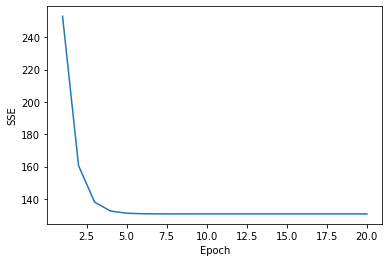

In [5]:
X = df[['RM']].values
y = df[['MEDV']].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [6]:
# Helper function that will plot a scatterplot of the training examples and add the regression line: 
# Will Visualize how well the linear regression line fits the training data

def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

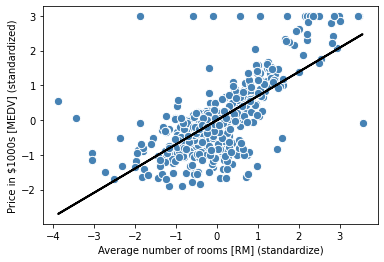

In [7]:
# Plot the number of rooms against the house price

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardize)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In certain application, it may also be important tp report the predicted outcome variables on their original scale. To scale the prodicted price outcome back onto the Price in USD 1000s axis, we can simply apply the inverse_transform method of the StandardScaler:

In [8]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % \
      sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


In this code example, we used the previously trained linear regression model to predict the price of a house with five rooms. According to our model, such a house will be worth USD 10,840.

### Estimating the coefficient of a regression model via scikit-learn

Using scikit-learn, the regression model implemetation becomes more efficient and it also works better with unstandardized variables, since it does not use (S)GD-based optimization, so we can skip the standardization step:

Slope: 9.102
Intercept: -34.671
---------------


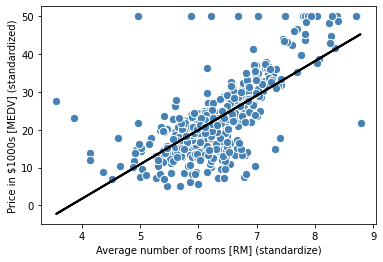

In [9]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X)

print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)
print("---------------")

lin_regplot(X,y,slr)
plt.xlabel('Average number of rooms [RM] (standardize)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [10]:
# What is the price if there are five rooms? (y = mx + b)
house_price_ = (slr.coef_[0]*5) + slr.intercept_
print("Price in $1000s: %.3f" % \
      house_price_)

Price in $1000s: 10.840


The unstandardized linear regression model provides the same answer as the gradient descent optimized standardized variables method above. The five room house is still worth USD 10,840. 

## Fitting a robust regression model using RANSAC

Linear regression models can be heavily impacted by the presence of outliers. In certain situations, a very small subset of our data can have a big effect on the estimated model coefficients. In addition, removing outliers always requires our own judgement as data scientists as well as our domain knowledge.

Therefore, as an alternative to removing outliers, __RAN__dom __SA__mple __C__onsensus __(RANSAC)__ algorithm, which fits a regression model to a subset of the data, the so-called __inliers__.

We can summarize the iterative RANSAC algorithms as follows:

1. Select a random number of examples to be inliers and fit the model.
2. Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers.
3. Refit the model using all inliers.
4. Estimate the error of the fitted model versus the inliers.
5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations were reached; go back to step 1 otherwise.

Slope: 10.735
Intercept: -44.089
------------------------------------------------------


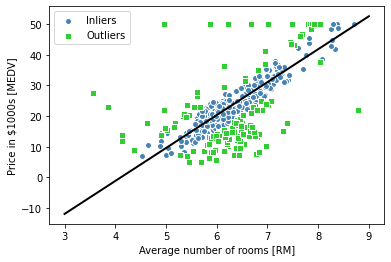

In [11]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100, # set the maximum number of iterations of the RANSACRegressor to 100 
                         min_samples=50, # set the minimum number of the randomly chosen training examples to be at least 50
                         loss='absolute_loss', # Using absolute_loss as an arg for the loss parameter, the algo computes absolute vertical distances between the fitted line and the training examples
                         residual_threshold=5.0, # By setting the residual_threshold to 5.0, we only allow training examples to be included in the inliers set if their vertical distance to the fitted line is within 5 distance unit, which will work well on this particular dataset
                         random_state=0)
ransac.fit(X, y)

# AFter fitting the RANSAC, let's obtain the inliers and outliers from the fitted RANSAC-linear regression model and plot them together with the linear fit:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask], 
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], 
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')

print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)
print('------------------------------------------------------')

plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [12]:
# What is the price if there are five rooms? (y = mx + b)
house_price_ransac = (ransac.estimator_.coef_[0]*5) + ransac.estimator_.intercept_
print("Price in $1000s: %.3f" % \
      house_price_ransac)

Price in $1000s: 9.583


RANSAC linear regression predicts that the house with five rooms is worth USD 9,583. Using RANSAC, we reduced the potential of the outliers in this dataset but we don't know whether this approach will have a positive effect on the predictive performance for unseen data or not. Thus, in the next section, we will look at different approaches for evaluating a regression model, which is a crucial part of building systems for predictive modeling.

## Evaluating the performance of linear regression models

In the above sections, we have covered how to fit a regression model on training data. However, it is important to test the model on data that it hasn't seen during training to obtain a more unbiased estimate of its generalization performance. Therefore, as __Best Practices for Model Evaluation and Hyperparameter Tuning__, we want to split our dataset into seperate training and test performance on unseen data to estimate the generalization performance.

Instead of proceeding with the simple regression model, we will now use all variables in the dataset and train a multiple regression model:

In [13]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression() #This is already written above but it is included here because you might miss it if you are just doing this alone by referencing this.
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

Since the model uses multiple explanatory varaibles, we can't visualize the linear regression line (or hyperplane, to be precise) in a two-dimensional plot, but we can plot the rediduals (the differences or vertical distances between the actual and predicted values) versus the predicted values to diagnose our regression model. __Residual plots__ are a commonly used graphical tool for diagnosing regression models. They can help to detect nonlinearity and outliers, and check whether the errors are randomly distributed.

Using the following code, we will now plot a residual plot where we simply subtract the true target variables from our predicted responses:

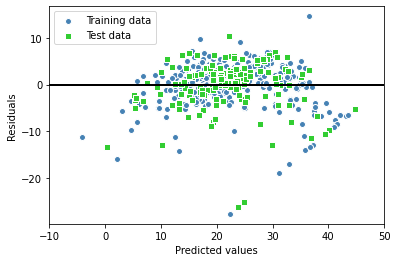

In [14]:
plt.scatter(y_train_pred, y_train_pred - y_train, 
            c='steelblue', marker='o', edgecolor='white', 
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', marker='s', edgecolor='white', 
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10,50])
plt.show()

In the case of perfect prediction, the residuals would be exactly zero, but that will never happen in real life. For a good regression model, we would expect the errors to be randomly distributed and the residuals to be randomly scattered around the centerline. If we see patterns in a residuals plot, it means that our model is unable to capture some explanatory information, which has leaked into the residuals, as you can slightly see in above scatter plot. Furthermore, we can also use residual plots to detect outliers, which are represented by points with a large deviation from the centerline.

Another useful quantitative measures of a model's performance is the __mean squared error (MSE)__, which is simply the averaged value of the SSE cost that we minimized to fit the linear regression model. The MSE is useful for comparing different regression models or for tuning their parameters via grid search and cross-validation, as it normalizes the SSE by the sample size.

Let's compute the MSE of our training and test predictions:

In [15]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
       mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


You can see that the MSE on the training dataset is 19.96, and the MSE on the test dataset is much larger, with a value of 27.20, which is an indicator that our model is __overfitting__ the training data in this case. However, please be aware that the MSE is unbounded in contrast to the classification accuracy, for example. In other words, the interpretation of the MSE depends on the dataset and feature scaling. For example, if the housing prices were presented as multiples of 1,0-00 (with the K suffix), the same model would ywild a lower MSE compared to a model that worked with unscaled features. To further illustrate this point, (USD 10K < 15K)^2 < (USD 10,000 - 15,000)^2.

Thus, it may sometimes be more useful to report the __coefficient of determination (R^2)__, which can be understood as a standardized version of the MSE, for better interpretability of the model's performance.

For the training dataset, the R^2 is bounded between 0 and 1, but it can become negative for the test dataset. If R^2 = 1, the model fits the data perfectly with a corresponding MSE = 0.

In [16]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' %
      (r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


Evaluated on the training data, the R^2 of our model is 0.765 which doesn't sound too bad. However, the R^2 on the test dataset is only 0.673 which is not too good.

## Using regularized methods for regression

Regularization is one approach to __tackle the problem of overfitting__ by adding additional information, and thereby shrinking the parameter values of the model to induce a penalty against complexcity. The most popular approaches to regularized linear regression are __Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO)__, and __Elastic Net__.

Ridge Regression is a L2 penalized model where we simply add the squared sum of the weights to out least-squares cost function. By increasing the value of hyperparameter, we increase the regularization stregth and thereby shrink the weights of our model.

An alternative approach that can lead to sparse models is LASSO, an L1 penalized model. Depending on the regularization strength, certain weights can become zero, which also makes LASSO useful as a supervised feature selection technique. However, the limitation of LASSO is that it selects at most n features if m > n, where n is the number of training examples. This may be undesirable in certain applications of feature selection. In practice, however, this property of LASSO is often an advantage becasue it avoids saturated models. Saturation of a model occurs if the number of training examples is equal to the number of features, which is a form of overparameterization, As a consequence, a saturated model can always fit the training data perfectly but is merely a form of interpolation (the insertion of an intermediate value by estimating or calculating it from surrounding known values) and thus is not expected to generalize well.

A compromise between Ridge Regression and LASSO is elastic net, which has an L1 penalty to generate sparsity and an L2 penalty such that it can be used for selecting more thatn n features if m > n.

Those regularized regression model is all available via scikit-learn, and their usage is similar to the regular regression model except that we have to specify the regularization strength via the parameter λ, for example, optimized via k-fold cross validation.

In [17]:
# Ridge Regression Model

from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
print('MSE train: %.3f, test: %.3f | R^2 train: %.3f, test: %.3f' % (
       mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred),
       r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))

MSE train: 20.145, test: 27.762 | R^2 train: 0.762, test: 0.667


Note that regularization strength is regulated by the parameter alpha, which is similar to the parameter λ.

In [18]:
# LASSO Model

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print('MSE train: %.3f, test: %.3f | R^2 train: %.3f, test: %.3f' % (
       mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred),
       r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))

MSE train: 24.717, test: 32.345 | R^2 train: 0.708, test: 0.612


Lastly, the ElasticNet implementation allows is to vary the L1 to L2 ratio:

In [19]:
# Elastic Net

from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio = 0.5)
elanet.fit(X_train, y_train)
y_train_pred = elanet.predict(X_train)
y_test_pred = elanet.predict(X_test)
print('MSE train: %.3f, test: %.3f | R^2 train: %.3f, test: %.3f' % (
       mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred),
       r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))

MSE train: 24.381, test: 31.874 | R^2 train: 0.712, test: 0.617


For example, if we set the l1_ratio to 1.0, the ElasticNet regressor would be equal to LASSO regression.

## Turning a linear regression model into a curve — polynomial regression

In the above sections, we assumed a linear relationship between explanatory and response variables. One way to account for the violation of linearity assumption is to use a ploynomial regression model by adding polynomial terms:

``` y = w0 + w1x + w2x^2 + ... + wdw^d ```

Here, d denotes the degree of the polynomial. Although we can use polynomial regression to model a nonlinear relationship, it is still considered a multiple linear regression model because of the linear regression coefficients, w.

### Adding polynomial terms using scikit-learn

We will now learn how to use the ```PolynomialFeatures``` transformer class from scikit-learn to add a quadratic term (d=2) to a simple regression problem with one explanatory variable. Then we will compare the polynomial to the linear fit by following these steps:

1. Add a second-degree polynomial term.
2. Fit a simple linear regression model for comparison.
3. Fit a multiple regression model on the transformed features for polynomial regression.
4. Plot the results.

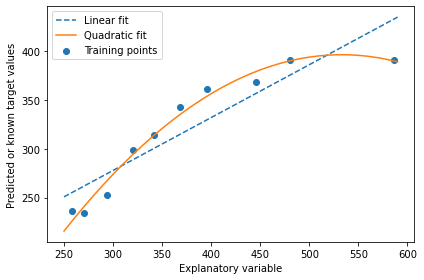

In [20]:
# 1.Add a second-degree polynomial term.
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0,270.0,294.0,320.0,342.0,
              368.0,396.0,446.0,480.0,586.0])\
              [:,np.newaxis]
y = np.array([236.4,234.4,252.8,298.6,314.2,
              342.2,360.8,368.0,391.2,390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

# 2.Fit a simple linear regression model for comparison.
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# 3.Fit a multiple regression model on the transformed features for polynomial regression.
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# 4.Plot the results.
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, 
         label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, 
         label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In the above plot, you can see that the polynomial fit captures the relationship between the response and explanatory variables much better than the linear fit.

Next, we will compute the MSE and R^2 evaluation metrics:

In [21]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f | Training R^2 linear: %.3f, quadratic: %.3f' % (
    mean_squared_error(y, y_lin_pred), mean_squared_error(y, y_quad_pred), r2_score(y, y_lin_pred), r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330 | Training R^2 linear: 0.832, quadratic: 0.982


As you can see after executing the code, the MSE decreased from 570 (linear fit) to 61 (quadratic fit); also the coefficient of the determination reflects a closer fit of the quadratic model (R^2=0.982) as opposed to the linear fit (R^2 = 0.832) in this particular toy problem.

### Modeling nonlinear relationships in the Housing dataset

Now, we can apply the above concept into the housing dataset. By executing the following code, we will model the relationship between house prices and ```LSTAT``` (percentage of lower status of the population) using second-degree (quadratic) and third-degree (cubic) polynomials and compare that to a linear fit:

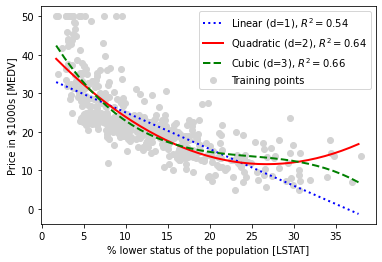

In [22]:
X = df[['LSTAT']].values
y = df[['MEDV']].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit feature
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

#plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='Linear (d=1), $R^2=%.2f$' % linear_r2,
         color='blue',
         lw=2,
         linestyle=':')
plt.plot(X_fit, y_quad_fit, 
         label='Quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red',
         lw=2,
         linestyle='-')
plt.plot(X_fit, y_cubic_fit, 
         label='Cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green',
         lw=2,
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

In the above chart, the cubic fit captures the relationship between the house prices and LSTAT better than the linear and quadratic fit. However, you should be aware that adding more and more polynomial features increases the complexity of a model and therefore increases the chance of overfitting. Thus, in practice it is always recommended to evaluate the performance of the model on a separate test dataset to estimate the generalized performance.

In addition, polynomial features are not always the best choice for modeling nonlinear relationships. For example, with some experience or intuition, just looking at the MEDV-LSTAT scatterplot may lead to the hypothesis that a log-transformation of the LSTAT feature variable and the square root of MEDV may project the data onto a linear feature space suitable for a linear regression fit. For instance, the relationship between the two variable looks quite similar to an exponential function:

```f(x) = e^-x```

Since the natural log of an exponential function is a straight line, log-transformation can be usefully applied here as:

```log(f(x)) = -x```

Let's test this hypothesis by executing the following code:

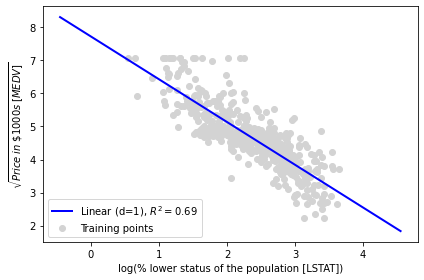

In [23]:
# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, 
            label='Training points', 
            color='lightgray')
plt.plot(X_fit, y_lin_fit, 
            label='Linear (d=1), $R^2=%.2f$' % linear_r2, 
            color='blue', 
            lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Dealing with nonlinear relationships using random forests

In this section, we are going to take a look at a __random forest__ regression, which is conceptually different from the previous regression models. A random forest, which is an ensemble of multiple decision trees, can be understood as the sum of piecewise linear functions, in contrast to the global linear and polynomial regression models that we discussed previously. In other words, via the decision tree algorithm, we subdivide the input space onto smaller regions that become mpre manageable.

### Decision tree regression

An advantage of the decision tree algorithm is that it does not require any transformation of the features if we are dealing with nonlinear data, because decision trees analyze one feature at a time, rather than taking weighted combinations into account. (Likewise, normalizing or standardizing features is not required for decision trees.)

In context of decision tree regression, the MSE is often reffered to as __within-node variance__, which is why the splitting criterion is also better known as variance reduction. To see what the line fit of a decision tree look like, let's use the ```DecisionTreeRegressor``` implemeted in scikit-learn to model the nonlinear relationship between the MEDV and LSTAT variables:

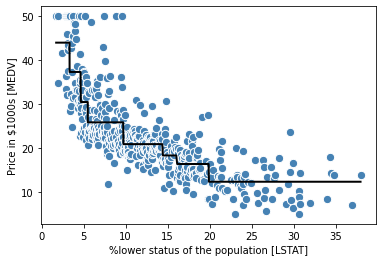

In [24]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df[['MEDV']].values
tree = DecisionTreeRegressor(max_depth = 3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)

plt.xlabel('%lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

As you can see in the resulting plot, the decision tree captures the general trend in the data. However, a limitation of this model is that it does not capture the continuity and differentiability of the desired prediction. In addition, we need to be careful about choosing an appropriate value for the depth of the tree so as to not overfit or underfit the data; here, a depth of three seemed to be a good choice.

In the next section, we will take a look at a more robust way of fitting regression trees: random forests.

### Random forest regression

The random forest algorithm is an ensemble technique that combines multiple decision trees. A random forest usually has a better generalization performance than an individual decision tree due to randomness, which helps to decrease the model's variance. Other advantages of random forests are that they are less sensitive to outliers in the dataset and don't require much parameter tuning. The only parameter in random forest that we typically need to experiment with is the number of trees in the ensemble.

The basic random forest algorithm for regression is almost identical to the random forest algorithm for classification. The only difference is that we use the MSE criterion to grow the individual decision trees, and the predicted target variable is calculated as the average prediction over all decision trees.

Now, let's use all the features in the housing dataset to fit a random forest regression model on 60 percent of the examples and evaluate its performance on the remaining 40 percent. The code is as follows:

In [25]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse',
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f | R^2 train: %.3f, test: %.3f' % (
       mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred),
       r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))

MSE train: 1.644, test: 11.085 | R^2 train: 0.979, test: 0.877


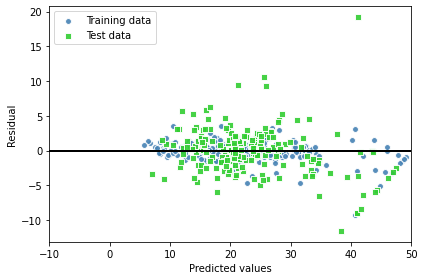

In [26]:
plt.scatter(y_train_pred, 
            y_train_pred - y_train, 
            c='steelblue', 
            edgecolor='white', 
            marker='o', 
            s=35, 
            alpha=0.9, 
            label='Training data')
plt.scatter(y_test_pred, 
            y_test_pred - y_test, 
            c='limegreen', 
            edgecolor='white', 
            marker='s', 
            s=35, 
            alpha=0.9, 
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

As it was already summarized by the R^2 coefficient, you can see that the model fits the training data better than the test data, as indicated by the outliers in the y-axis direction. Also, the distributed of the residuals does not seem to be completely random around the sero center point, indicating that the model is not able to capture all the explanatory information. However, the residual plot indicates a large improvement over the residual plot of the linear model that we plotted earlier above.

Ideally, our model error should be random or unpredictable. In other words, the error of the prediction should not be related to any of the information contained in the explanatory variables; rather, it should reflect the randomness of the real-world distributions or patterns. If we find patterns in the prediction errors, for example, by inspecting the residual plot, it means that the residual plots contain predictive information. A common reason for this could be that explanatory information leaking into those residuals.

Unfortunately, there is not a universal approach for dealing with non-randomness in residual plots, and it requires experimentaion. Depending on the data that is available to us, we may be able to improve the model by transforming variables, tuning the hyperparameters of the learning algorithm, choosing simpler or more complex models, removing outliers, or including addtional variables.